In [1]:
%load_ext autoreload
%autoreload 2 
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from vFMM_multi import *
from s_attention import *

In [2]:
Transformer = SwinTransformer(img_size=1023, patch_size=5, in_chans=1, num_classes=1000,
             embed_dim=128, depths=[1, 2, 1], num_heads=[1, 1, 1],
             window_size=4, mlp_ratio=4., qkv_bias=True, qk_scale=None,
             drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
             norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
             use_checkpoint=False).cuda()

# x = torch.rand(2, 128, 112, 112)
x = torch.rand(5, 1, 1023, 1023).cuda()
# pos = torch.rand(2, 256*256, 2).cuda()
#记得改服务器特供！
out = Transformer(x)
print(out.shape)

torch.Size([5, 65536, 128])


In [52]:
H, W, window_size, shift_size = 8, 8, 4, 1
img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
h_slices = (slice(0, -window_size),
            slice(-window_size, -shift_size),
            slice(-shift_size, None))
w_slices = (slice(0, -window_size),
            slice(-window_size, -shift_size),
            slice(-shift_size, None))
cnt = 0
for h in h_slices:
    for w in w_slices:
        img_mask[:, h, w, :] = cnt
        cnt += 1

mask_windows = window_partition(img_mask,  window_size)  # nW, window_size, window_size, 1
mask_windows = mask_windows.view(-1,  window_size *  window_size)
attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

In [53]:
mask_windows.shape

torch.Size([4, 16])

In [45]:
attn_mask.shape

torch.Size([4, 16, 16])

In [54]:
print(attn_mask[3, :, :])

tensor([[   0.,    0.,    0., -100.,    0.,    0.,    0., -100.,    0.,    0.,
            0., -100., -100., -100., -100., -100.],
        [   0.,    0.,    0., -100.,    0.,    0.,    0., -100.,    0.,    0.,
            0., -100., -100., -100., -100., -100.],
        [   0.,    0.,    0., -100.,    0.,    0.,    0., -100.,    0.,    0.,
            0., -100., -100., -100., -100., -100.],
        [-100., -100., -100.,    0., -100., -100., -100.,    0., -100., -100.,
         -100.,    0., -100., -100., -100., -100.],
        [   0.,    0.,    0., -100.,    0.,    0.,    0., -100.,    0.,    0.,
            0., -100., -100., -100., -100., -100.],
        [   0.,    0.,    0., -100.,    0.,    0.,    0., -100.,    0.,    0.,
            0., -100., -100., -100., -100., -100.],
        [   0.,    0.,    0., -100.,    0.,    0.,    0., -100.,    0.,    0.,
            0., -100., -100., -100., -100., -100.],
        [-100., -100., -100.,    0., -100., -100., -100.,    0., -100., -100.,
    

In [46]:
attn_mask.unsqueeze(1).unsqueeze(0).shape

torch.Size([1, 4, 1, 16, 16])

In [2]:
class HsLoss(object):
    def __init__(self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True, res=256):
        super().__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average
        self.res = res
        if a == None:
            a = [1,] * k
        self.a = a
        k_x = torch.cat((torch.arange(start=0, end=res//2, step=1),torch.arange(start=-res//2, end=0, step=1)), 0).reshape(res,1).repeat(1,res)
        k_y = torch.cat((torch.arange(start=0, end=res//2, step=1),torch.arange(start=-res//2, end=0, step=1)), 0).reshape(1,res).repeat(res,1)
        self.k_x = (torch.abs(k_x)*(torch.abs(k_x)<20)).reshape(1,res,res,1) 
        self.k_y = (torch.abs(k_y)*(torch.abs(k_y)<20)).reshape(1,res,res,1) 
        
    def cuda(self, device):
        self.k_x = self.k_x.to(device)
        self.k_y = self.k_y.to(device)

    def cpu(self):
        self.k_x = self.k_x.cpu()
        self.k_y = self.k_y.cpu()

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)
        return diff_norms/y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], self.res, self.res, -1)
        y = y.view(y.shape[0], self.res, self.res, -1)

        

        x = torch.fft.fftn(x, dim=[1, 2], norm='ortho')
        y = torch.fft.fftn(y, dim=[1, 2], norm='ortho')

        if balanced==False:
            weight = 1
            if k >= 1:
                weight += a[0]**2 * (self.k_x**2 + self.k_y**2)
            if k >= 2:
                weight += a[1]**2 * (k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x*weight, y*weight)
            l2loss = self.rel(x, y)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x*weight, y*weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
                loss += self.rel(x*weight, y*weight)
            loss = loss / (k+1)

        return loss, l2loss, x[:, :, 0], y[:, :, 0]

In [3]:
config={
        "modes": 12,
        "width": 32,
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 20,
        "sampling_rate": 4,
        "padding": None,
        "optimizer_type": 'adam',
        "loss_type": 'h1',
        "epochs": 50,
    }
for key, val in config.items():
    exec(key + '=val')
locals().update(config)

In [4]:
################################################################
# configs
################################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAIN_PATH = os.path.join(os.path.abspath(''), 'data/mul_res1023_a4f1_train.mat')
TEST_PATH = os.path.join(os.path.abspath(''), 'data/mul_res1023_a4f1_test.mat')

ntrain = 1000
ntest = 100

epochs = epochs
step_size = 100
gamma = 0.5


r = sampling_rate
h = int(((1023 - 1)//r) + 1)
s = h

################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)
# x_train[:, np.newaxis, :, :]
# x_train = reader.read_field('coeff')[:, np.newaxis, :, :]
x_train = reader.read_field('coeff')[:ntrain,...]
# x_train = reader.read_field('coeff')[:ntrain,::r,::r][:,:s,:s]
y_train = reader.read_field('sol')[:ntrain,::r,::r][:,:s,:s]

reader.load_file(TEST_PATH)
x_test = reader.read_field('coeff')[:ntest,...]
y_test = reader.read_field('sol')[:ntest,::r,::r][:,:s,:s]

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_normalizer.cuda(device)

x_train = x_train[:, np.newaxis, ...]
x_test = x_test[:, np.newaxis, ...]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train.contiguous(), y_train.contiguous()), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test.contiguous(), y_test.contiguous()), batch_size=batch_size, shuffle=False)


In [5]:
################################################################
# training and evaluation
################################################################
# model = FMMTransformer(img_size=1023, patch_size=4, in_chans=1, num_classes=2,
#                  embed_dim=width, depths=[1, 1, 1], num_heads=[1, 1, 1],
#                  window_size=[8, 8, 8], mlp_ratio=4., qkv_bias=False, qk_scale=None,
#                  drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
#                  norm_layer=nn.LayerNorm, ape=False, patch_norm=None,
#                  use_checkpoint=False, stride=sampling_rate).to(device)
model = SwinTransformer(img_size=1023, patch_size=5, in_chans=1, num_classes=1000,
             embed_dim=30, depths=[1, 1, 1], num_heads=[1, 1, 1],
             window_size=4, mlp_ratio=4., qkv_bias=True, qk_scale=None,
             drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
             norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
             use_checkpoint=False).cuda()

FNOdecoder = FNO2d(modes, modes, width, num_spectral_layers=num_spectral_layers, mlp_hidden_dim=mlp_hidden_dim, mode_threshold=mode_threshold, kernel_type=kernel_type, padding=padding).to(device)
print(count_params(model) + count_params(FNOdecoder))

if optimizer_type.lower()=='adam':
    optimizer = Adam(set(model.parameters()) | set(FNOdecoder.parameters()), lr=learning_rate, weight_decay=weight_decay)
else:
    optimizer = torch.optim.AdamW(set(model.parameters()) | set(FNOdecoder.parameters()), lr=learning_rate, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                           div_factor=1e1, 
                           final_div_factor=1e1,
                           pct_start=0.1,
                           steps_per_epoch=1, 
                           epochs=epochs)
h1loss = HsLoss(d=2, p=2, k=1, size_average=False, res=s, a=[2.,])
h1loss.cuda(device)
l2loss = LpLoss(size_average=False)  

train_h1_rec, train_l2_rec, train_f_dist_rec, test_l2_rec, test_h1_rec = [], [], [], [], []

with tqdm(total=epochs) as pbar_ep:

    for epoch in range(epochs):
        model.train()
        FNOdecoder.train()
        train_l2, train_h1, train_f_l2 = 0, 0, 0
        train_f_dist = torch.zeros(s)
        for x, y in train_loader:
            x, y = x.to(device), y.to(device) 
            optimizer.zero_grad()
            out = torch.squeeze(FNOdecoder(model(x).view(-1,256,256,30)))
            out = y_normalizer.decode(out)
            if loss_type=='h1':
                with torch.no_grad():
                    train_l2loss = l2loss(out, y)

                train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                train_h1loss.backward()
            else:
                with torch.no_grad():
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                train_l2loss = l2loss(out, y)
                train_l2loss.backward()

            optimizer.step()
            train_h1 += train_h1loss.item()
            train_l2 += train_l2loss.item()
            train_f_l2 += train_f_l2loss.item()
            train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        FNOdecoder.eval()
        test_l2, test_h1 = 0., 0.
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = torch.squeeze(FNOdecoder(model(x).view(-1,256,256,30)))
                out = y_normalizer.decode(out)
                test_l2 += l2loss(out, y).item()
                test_h1 += h1loss(out, y)[0].item()

        train_l2/= ntrain
        train_f_l2/= ntrain
        train_h1/= ntrain
        test_l2 /= ntest
        test_h1/= ntest
        train_f_dist/= ntrain
        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
        train_f_dist_rec.append(train_f_dist)
        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f"| current lr: {lr:.3e}"
        desc += f"| train l2 loss: {train_l2:.3e} "
        desc += f"| train f_l2 loss: {train_f_l2:.3e} "
        desc += f"| train h1 loss: {train_h1:.3e} "
        desc += f"| val l2 loss: {test_l2:.3e} "
        desc += f"| val h1 loss: {test_h1:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

2445668


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
loss_type=='l2'
learning_rate=6e-4
optimizer_type='adamw'
if optimizer_type.lower()=='adam':
    optimizer = Adam(set(model.parameters()) | set(FNOdecoder.parameters()), lr=learning_rate, weight_decay=weight_decay)
else:
    optimizer = torch.optim.AdamW(set(model.parameters()) | set(FNOdecoder.parameters()), lr=learning_rate, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                           div_factor=1e1, 
                           final_div_factor=1e1,
                           pct_start=0.1,
                           steps_per_epoch=1, 
                           epochs=epochs)
h1loss = HsLoss(d=2, p=2, k=1, size_average=False, res=s, a=[2.,])
h1loss.cuda(device)
l2loss = LpLoss(size_average=False)  

train_h1_rec, train_l2_rec, train_f_dist_rec, test_l2_rec, test_h1_rec = [], [], [], [], []

with tqdm(total=epochs) as pbar_ep:

    for epoch in range(epochs):
        model.train()
        FNOdecoder.train()
        train_l2, train_h1, train_f_l2 = 0, 0, 0
        train_f_dist = torch.zeros(s)
        for x, y in train_loader:
            x, y = x.to(device), y.to(device) 
            optimizer.zero_grad()
            out = torch.squeeze(FNOdecoder(model(x).view(-1,256,256,30)))
            out = y_normalizer.decode(out)
            if loss_type=='h1':
                with torch.no_grad():
                    train_l2loss = l2loss(out, y)

                train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                train_h1loss.backward()
            else:
                with torch.no_grad():
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                train_l2loss = l2loss(out, y)
                train_l2loss.backward()

            optimizer.step()
            train_h1 += train_h1loss.item()
            train_l2 += train_l2loss.item()
            train_f_l2 += train_f_l2loss.item()
            train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        FNOdecoder.eval()
        test_l2, test_h1 = 0., 0.
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = torch.squeeze(FNOdecoder(model(x).view(-1,256,256,30)))
                out = y_normalizer.decode(out)
                test_l2 += l2loss(out, y).item()
                test_h1 += h1loss(out, y)[0].item()

        train_l2/= ntrain
        train_f_l2/= ntrain
        train_h1/= ntrain
        test_l2 /= ntest
        test_h1/= ntest
        train_f_dist/= ntrain
        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
        train_f_dist_rec.append(train_f_dist)
        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f"| current lr: {lr:.3e}"
        desc += f"| train l2 loss: {train_l2:.3e} "
        desc += f"| train f_l2 loss: {train_f_l2:.3e} "
        desc += f"| train h1 loss: {train_h1:.3e} "
        desc += f"| val l2 loss: {test_l2:.3e} "
        desc += f"| val h1 loss: {test_h1:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [42]:
xs = torch.linspace(0, 1, steps=1023)
ys = torch.linspace(0, 1, steps=1023)
x, y = torch.meshgrid(xs, ys)

In [74]:
z, zp = next(iter(train_loader))

In [75]:
z[0,0,...]

tensor([[ 0.0000,  0.3739,  0.2845,  ..., -0.4343, -0.4316,  0.0000],
        [-0.3744, -0.4343, -0.4540,  ...,  0.0272, -0.2305, -0.3744],
        [ 0.2832, -0.0854, -0.3496,  ...,  0.3842,  0.4505,  0.2832],
        ...,
        [-0.0063, -0.0681, -0.1667,  ..., -0.1409, -0.0173, -0.0063],
        [ 0.3103,  0.2673,  0.1662,  ..., -0.2713,  0.2845,  0.3103],
        [ 0.0000,  0.3739,  0.2845,  ..., -0.4343, -0.4316,  0.0000]])

In [76]:
z.shape

torch.Size([20, 1, 1023, 1023])

In [77]:
zp.shape

torch.Size([20, 512, 512])

In [51]:
X = np.linspace(0, 1, 1023)
Y = np.linspace(0, 1, 1023)

In [ ]:
TRAIN_PATH = os.path.join(os.path.abspath(''), 'data/mul_res1023_a3f2_train.mat')

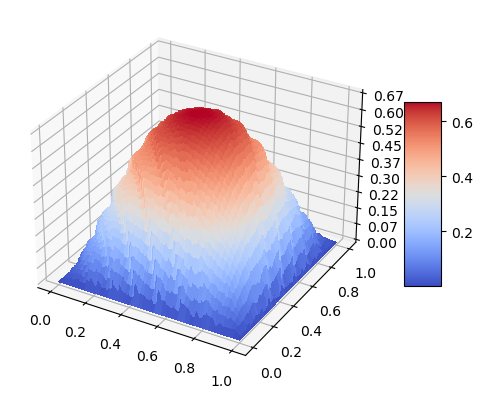

In [78]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.linspace(0, 1, 512)
Y = np.linspace(0, 1, 512)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = zp[0,...].cpu().numpy()
# Z = np.sin(R)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [80]:
z[0,0,::2,::2].cpu().numpy().min()

-1.5936557

In [82]:
z.min()

-2.547560453414917

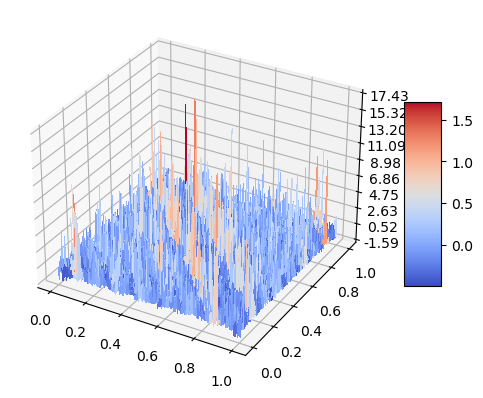

In [79]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.linspace(0, 1, 512)
Y = np.linspace(0, 1, 512)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = z[0,0,::2,::2].cpu().numpy()
# Z = np.sin(R)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [48]:
import plotly.figure_factory as ff
uplot = ff.create_trisurf(x=x, y=y, z=z[0,0,...],
                              colormap="Viridis",  # similar to matlab's default colormap
                              showbackground=True,
                              show_colorbar=False,
                              aspectratio=dict(x=1, y=1, z=1),
                              )
fig = go.Figure(data=uplot)

TypeError: create_trisurf() missing 1 required positional argument: 'simplices'

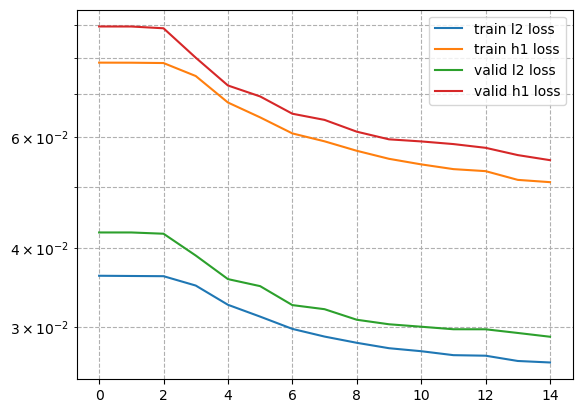

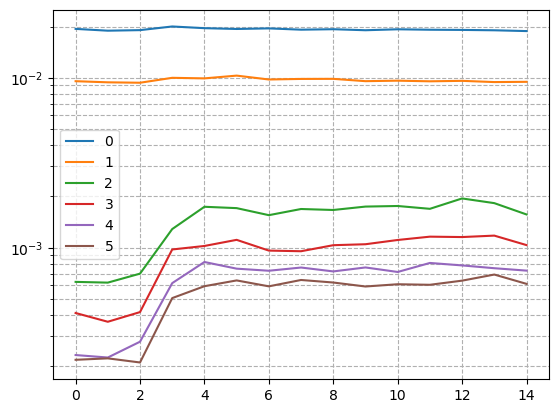

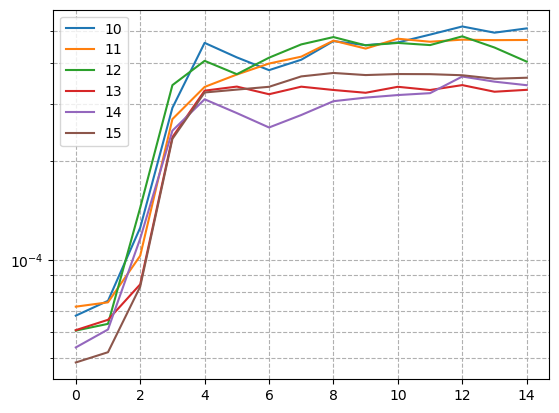

In [36]:
plt.figure(1)
plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

temp = torch.stack(train_f_dist_rec)
plt.figure()
plt.semilogy(temp[:, 0:6].detach().cpu().numpy())
plt.grid(True, which="both", ls="--")
plt.legend(range(6))
plt.show()

plt.figure()
plt.semilogy(temp[:, 10:16].detach().cpu().numpy())
plt.grid(True, which="both", ls="--")
plt.legend(range(10,16))
plt.show()

In [25]:
weight_decay = 1e-3
loss_type = 'l2'
if optimizer_type.lower()=='adam':
    optimizer = Adam(set(model.parameters()) | set(FNOdecoder.parameters()), lr=learning_rate, weight_decay=weight_decay)
else:
    optimizer = torch.optim.AdamW(set(model.parameters()) | set(FNOdecoder.parameters()), lr=learning_rate, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                           div_factor=1e1, 
                           final_div_factor=1e1,
                           pct_start=0.1,
                           steps_per_epoch=1, 
                           epochs=epochs)

with tqdm(total=epochs) as pbar_ep:

    for epoch in range(epochs):
        model.train()
        FNOdecoder.train()
        train_l2, train_h1, train_f_l2 = 0, 0, 0
        train_f_dist = torch.zeros(s)
        for x, y in train_loader:
            x, y = x.to(device), y.to(device) 
            optimizer.zero_grad()
            out = torch.squeeze(FNOdecoder(model(x).view(-1,256,256,30)))
            out = y_normalizer.decode(out)
            if loss_type=='h1':
                with torch.no_grad():
                    train_l2loss = l2loss(out, y)

                train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                train_h1loss.backward()
            else:
                with torch.no_grad():
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                train_l2loss = l2loss(out, y)
                train_l2loss.backward()

            optimizer.step()
            train_h1 += train_h1loss.item()
            train_l2 += train_l2loss.item()
            train_f_l2 += train_f_l2loss.item()
            train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        FNOdecoder.eval()
        test_l2, test_h1 = 0., 0.
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = torch.squeeze(FNOdecoder(model(x).view(-1,256,256,30)))
                out = y_normalizer.decode(out)
                test_l2 += l2loss(out, y).item()
                test_h1 += h1loss(out, y)[0].item()

        train_l2/= ntrain
        train_f_l2/= ntrain
        train_h1/= ntrain
        test_l2 /= ntest
        test_h1/= ntest
        train_f_dist/= ntrain
        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
        train_f_dist_rec.append(train_f_dist)
        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f"| current lr: {lr:.3e}"
        desc += f"| train l2 loss: {train_l2:.3e} "
        desc += f"| train f_l2 loss: {train_f_l2:.3e} "
        desc += f"| train h1 loss: {train_h1:.3e} "
        desc += f"| val l2 loss: {test_l2:.3e} "
        desc += f"| val h1 loss: {test_h1:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
torch.cuda.empty_cache()

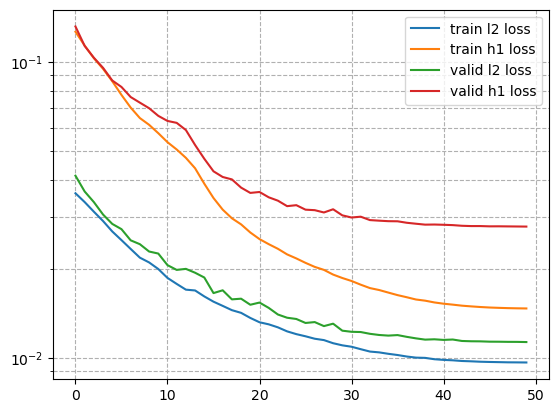

In [6]:
plt.figure(1)
plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

In [7]:
def train(**kargs):
    ################################################################
    # training and evaluation
    ################################################################
    model = FMMTransformer(img_size=1023, patch_size=4, in_chans=1, num_classes=2,
                     embed_dim=width, depths=[1, 1, 1], num_heads=[1, 1, 1],
                     window_size=[8, 8, 8], mlp_ratio=4., qkv_bias=False, qk_scale=None,
                     drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
                     norm_layer=nn.LayerNorm, ape=False, patch_norm=None,
                     use_checkpoint=False, stride=sampling_rate).to(device)

    FNOdecoder = FNO2d(modes, modes, width, num_spectral_layers=num_spectral_layers, mlp_hidden_dim=mlp_hidden_dim, mode_threshold=mode_threshold, kernel_type=kernel_type, padding=padding).to(device)
    print(count_params(model) + count_params(FNOdecoder))

    if optimizer_type.lower()=='torch.adam':
        optimizer = torch.optim.Adam(set(model.parameters()) | set(FNOdecoder.parameters()), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_type.lower()=='adam':
        optimizer = Adam(set(model.parameters()) | set(FNOdecoder.parameters()), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.AdamW(set(model.parameters()) | set(FNOdecoder.parameters()), lr=learning_rate, weight_decay=weight_decay)

    optimizer1 = Adam(FNOdecoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optimizer2 = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler1 = torch.optim.lr_scheduler.OneCycleLR(optimizer1, max_lr=learning_rate, 
                               div_factor=1e1, 
                               final_div_factor=1e1,
                               pct_start=0.1,
                               steps_per_epoch=1, 
                               epochs=epochs)
    scheduler2 = torch.optim.lr_scheduler.OneCycleLR(optimizer2, max_lr=learning_rate, 
                               div_factor=1e1, 
                               final_div_factor=1e1,
                               pct_start=0.1,
                               steps_per_epoch=1, 
                               epochs=epochs)
    
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
#                                div_factor=1e1, 
#                                final_div_factor=1e1,
#                                pct_start=0.1,
#                                steps_per_epoch=1, 
#                                epochs=epochs)
    h1loss = HsLoss(d=2, p=2, k=1, size_average=False, res=s, a=[2.,])
    h1loss.cuda(device)
    l2loss = LpLoss(size_average=False)  

    train_h1_rec, train_l2_rec, train_f_dist_rec, test_l2_rec, test_h1_rec = [], [], [], [], []

    with tqdm(total=epochs) as pbar_ep:

        for epoch in range(epochs):
            model.train()
            FNOdecoder.train()
            train_l2, train_h1, train_f_l2 = 0, 0, 0
            train_f_dist = torch.zeros(s)
            for x, y in train_loader:
                x, y = x.to(device), y.to(device) 
                optimizer.zero_grad()
                out = torch.squeeze(FNOdecoder(model(x)))
                out = y_normalizer.decode(out)
                if loss_type=='h1':
                    with torch.no_grad():
                        train_l2loss = l2loss(out, y)
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                    train_h1loss.backward()
                else:
                    with torch.no_grad():
                        train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                    train_l2loss = l2loss(out, y)
                    train_l2loss.backward()

#                 optimizer.step()
                optimizer1.step()
                optimizer2.step()
                train_h1 += train_h1loss.item()
                train_l2 += train_l2loss.item()
                train_f_l2 += train_f_l2loss.item()
                train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

            ############################
#             lr = optimizer.param_groups[0]['lr']
            lr = optimizer1.param_groups[0]['lr']

#             scheduler.step()
            scheduler1.step()
            scheduler2.step()

            model.eval()
            FNOdecoder.eval()
            test_l2, test_h1 = 0., 0.
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    out = torch.squeeze(FNOdecoder(model(x)))
                    out = y_normalizer.decode(out)
                    test_l2 += l2loss(out, y).item()
                    test_h1 += h1loss(out, y)[0].item()

            train_l2/= ntrain
            train_f_l2/= ntrain
            train_h1/= ntrain
            test_l2 /= ntest
            test_h1/= ntest
            train_f_dist/= ntrain
            train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
            train_f_dist_rec.append(train_f_dist)
            desc = f"epoch: [{epoch+1}/{epochs}]"
            desc += f"| current lr: {lr:.3e}"
            desc += f"| train l2 loss: {train_l2:.3e} "
            desc += f"| train f_l2 loss: {train_f_l2:.3e} "
            desc += f"| train h1 loss: {train_h1:.3e} "
            desc += f"| val l2 loss: {test_l2:.3e} "
            desc += f"| val h1 loss: {test_h1:.3e} "
            pbar_ep.set_description(desc)
            pbar_ep.update()
            
    plt.figure(1)
    plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
    plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
    plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
    plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

4507332


  0%|          | 0/50 [00:00<?, ?it/s]

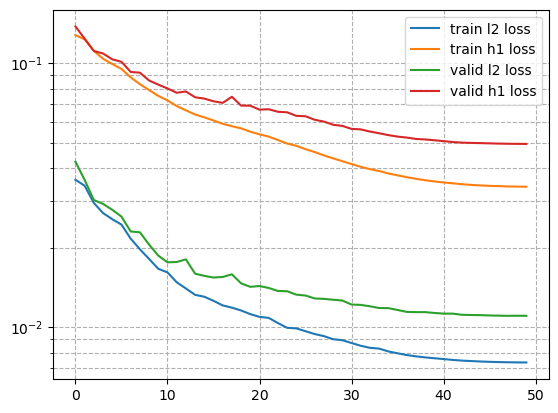

In [28]:
# use 'l2' loss 
config={
        "modes": 16,
        "width": 32,
        "learning_rate": 1e-3,
        "weight_decay": 1e-3,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 5,
        "sampling_rate": 4,
        "padding": 15,
        "optimizer_type": 'adamw',
        "loss_type": 'l2',
        "epochs": 50,
    }
locals().update(config)
train()

2672324


  0%|          | 0/50 [00:00<?, ?it/s]

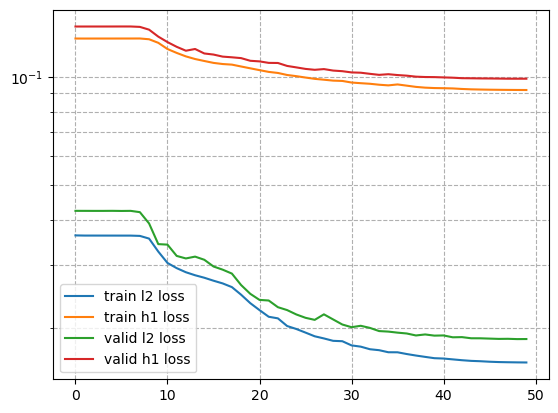

In [13]:
# use 'l2' loss， torch.adam for FNO and adamW for vFMM
config={
        "modes": 12,
        "width": 32,
        "learning_rate": 3e-4,
        "weight_decay": 1e-4,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 5,
        "sampling_rate": 4,
        "padding": 15,
        "optimizer_type": 'adam',
        "loss_type": 'l2',
        "epochs": 50,
    }
locals().update(config)
train()

2672324


  0%|          | 0/50 [00:00<?, ?it/s]

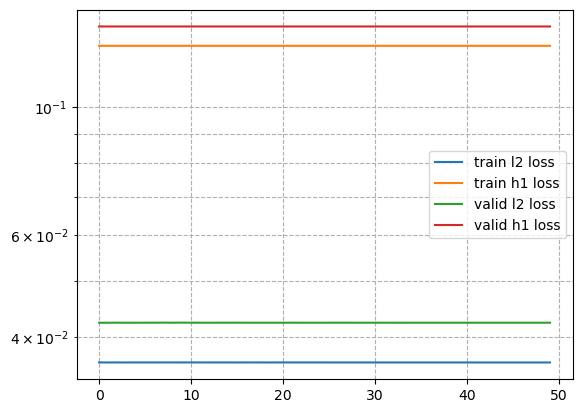

In [15]:
# use 'l2' loss， adam for both
config={
        "modes": 12,
        "width": 32,
        "learning_rate": 3e-4,
        "weight_decay": 1e-4,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 5,
        "sampling_rate": 4,
        "padding": 15,
        "optimizer_type": 'adam',
        "loss_type": 'l2',
        "epochs": 50,
    }
locals().update(config)
train()

2672324


  0%|          | 0/50 [00:00<?, ?it/s]

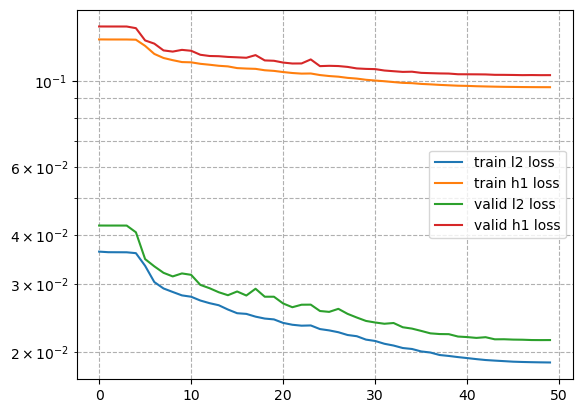

In [16]:
# use 'l2' loss， adam for both, batchsize=10
config={
        "modes": 12,
        "width": 32,
        "learning_rate": 3e-4,
        "weight_decay": 1e-4,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 10,
        "sampling_rate": 4,
        "padding": 15,
        "optimizer_type": 'adam',
        "loss_type": 'l2',
        "epochs": 50,
    }
locals().update(config)
train()

2672324


  0%|          | 0/50 [00:00<?, ?it/s]

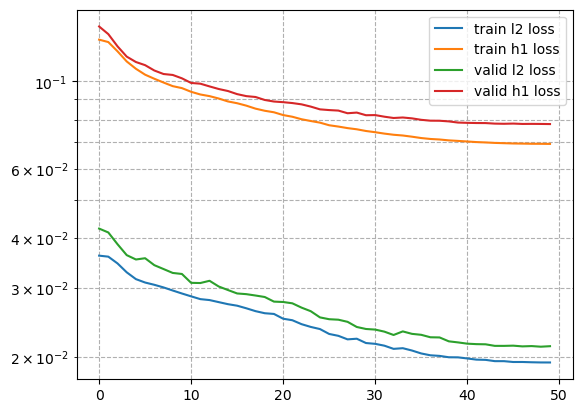

In [17]:
# use 'h1' loss， adam for both 
config={
        "modes": 12,
        "width": 32,
        "learning_rate": 3e-4,
        "weight_decay": 1e-4,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 10,
        "sampling_rate": 4,
        "padding": 15,
        "optimizer_type": 'adam',
        "loss_type": 'h1',
        "epochs": 50,
    }
locals().update(config)
train()

In [9]:
# use 'l2' loss， torch.adam  for baoth
config={
        "modes": 12,
        "width": 32,
        "learning_rate": 5e-4,
        "weight_decay": 1e-3,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 5,
        "sampling_rate": 4,
        "padding": 15,
        "optimizer_type": 'adam',
        "loss_type": 'l2',
        "epochs": 50,
    }
locals().update(config)
train()

2672324


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

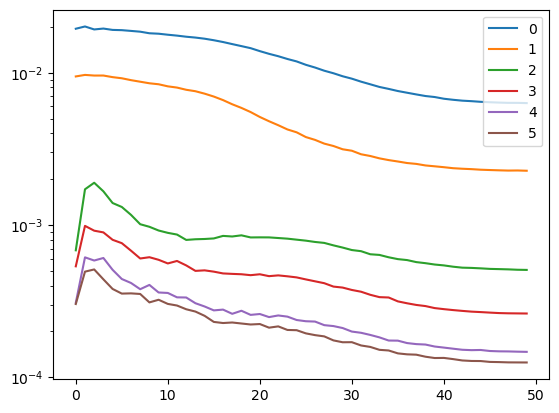

In [12]:
test = torch.stack(train_f_dist_rec)
plt.figure
plt.semilogy(test[:, 0:6].detach().cpu().numpy())
plt.legend(range(6))
plt.show()

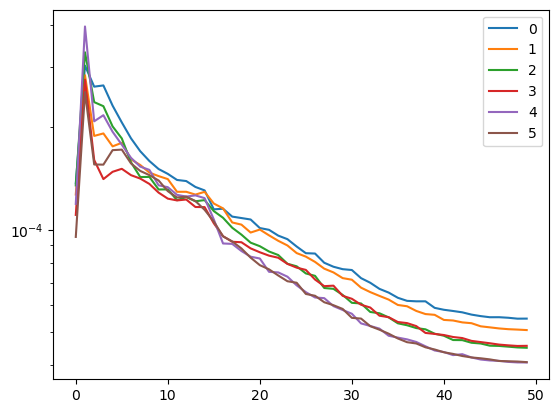

In [13]:
plt.figure
plt.semilogy(test[:, 10:16].detach().cpu().numpy())
plt.legend(range(6))
plt.show()

In [1]:
config={
        "modes": 16,
        "width": 32,
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 5,
        "sampling_rate": 4,
        "padding": 15,
        "optimizer_type": 'adamw',
        "loss_type": 'l2',
        "epochs": 50,
    }
for key, val in config.items():
    exec(key + '=val')

################################################################
# training and evaluation
################################################################
model = FMMTransformer(img_size=1023, patch_size=4, in_chans=1, num_classes=2,
                 embed_dim=width, depths=[1, 1, 1], num_heads=[1, 1, 1],
                 window_size=[8, 8, 8], mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=None,
                 use_checkpoint=False, stride=sampling_rate).to(device)

FNOdecoder = FNO2d(modes, modes, width, num_spectral_layers=num_spectral_layers, mlp_hidden_dim=mlp_hidden_dim, mode_threshold=mode_threshold, kernel_type=kernel_type, padding=padding).to(device)
print(count_params(model) + count_params(FNOdecoder))

if optimizer_type.lower()=='adam':
    optimizer = Adam(set(model.parameters()) | set(FNOdecoder.parameters()), lr=learning_rate, weight_decay=weight_decay)
else:
    optimizer = torch.optim.AdamW(set(model.parameters()) | set(FNOdecoder.parameters()), lr=learning_rate, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                           div_factor=1e1, 
                           final_div_factor=1e1,
                           pct_start=0.1,
                           steps_per_epoch=1, 
                           epochs=epochs)
h1loss = HsLoss(d=2, p=2, k=1, size_average=False, res=s, a=[2.,])
h1loss.cuda(device)
l2loss = LpLoss(size_average=False)  

train_h1_rec, train_l2_rec, train_f_dist_rec, test_l2_rec, test_h1_rec = [], [], [], [], []

with tqdm(total=epochs) as pbar_ep:

    for epoch in range(epochs):
        model.train()
        FNOdecoder.train()
        train_l2, train_h1, train_f_l2 = 0, 0, 0
        train_f_dist = torch.zeros(s)
        for x, y in train_loader:
            x, y = x.to(device), y.to(device) 
            optimizer.zero_grad()
            out = torch.squeeze(FNOdecoder(model(x)))
            out = y_normalizer.decode(out)
            if loss_type=='h1':
                with torch.no_grad():
                    train_l2loss = l2loss(out, y)

                train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                train_h1loss.backward()
            else:
                with torch.no_grad():
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                train_l2loss = l2loss(out, y)
                train_l2loss.backward()

            optimizer.step()
            train_h1 += train_h1loss.item()
            train_l2 += train_l2loss.item()
            train_f_l2 += train_f_l2loss.item()
            train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        FNOdecoder.eval()
        test_l2, test_h1 = 0., 0.
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = torch.squeeze(FNOdecoder(model(x)))
                out = y_normalizer.decode(out)
                test_l2 += l2loss(out, y).item()
                test_h1 += h1loss(out, y)[0].item()

        train_l2/= ntrain
        train_f_l2/= ntrain
        train_h1/= ntrain
        test_l2 /= ntest
        test_h1/= ntest
        train_f_dist/= ntrain
        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
        train_f_dist_rec.append(train_f_dist)
        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f"| current lr: {lr:.3e}"
        desc += f"| train l2 loss: {train_l2:.3e} "
        desc += f"| train f_l2 loss: {train_f_l2:.3e} "
        desc += f"| train h1 loss: {train_h1:.3e} "
        desc += f"| val l2 loss: {test_l2:.3e} "
        desc += f"| val h1 loss: {test_h1:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

NameError: name 'FMMTransformer' is not defined

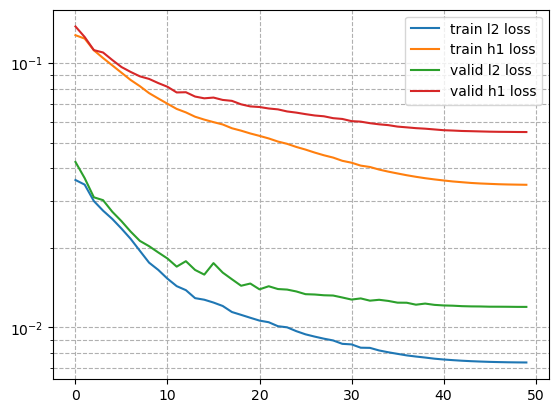

In [88]:
plt.figure(1)
plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

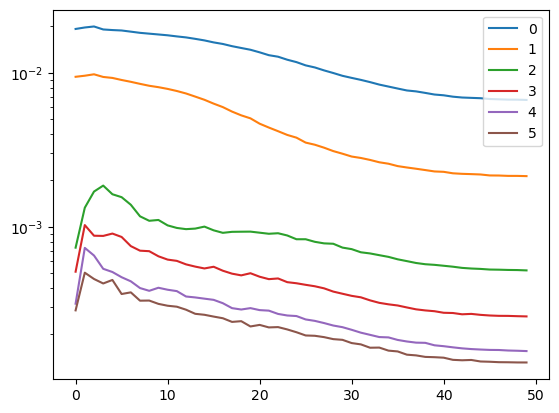

In [89]:
plt.figure
plt.semilogy(test[:, 0:6].detach().cpu().numpy())
plt.legend(range(6))
plt.show()

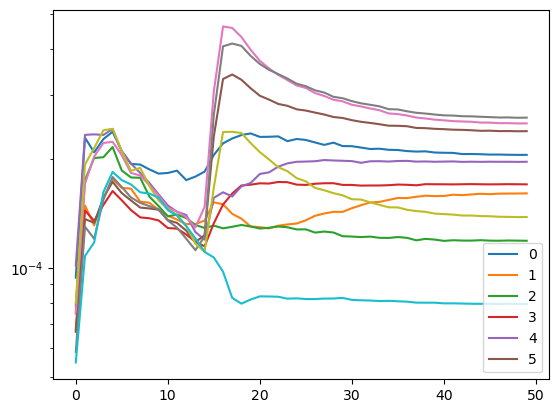

In [84]:
plt.figure
plt.semilogy(test[:, 20:30].detach().cpu().numpy())
plt.legend(range(6))
plt.show()